# Mastercurve Model Comparison

Template to compare multiple models on mastercurve data (polystyrene).

**Data:** examples/data/mastercurves/master_curve_ps_oscillation_data.csv

In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import FractionalMaxwellModel, GeneralizedMaxwell
from rheojax.pipeline.base import Pipeline
from rheojax.transforms.mastercurve import Mastercurve

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)
import os
import sys

import arviz as az

# Shared plotting utilities
sys.path.insert(0, os.path.join(os.path.dirname(os.path.abspath("")), ".."))
from utils.plotting_utils import display_arviz_diagnostics


## Load mastercurve (polystyrene)

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'mastercurves'
df = pd.read_csv(DATA_DIR / 'master_curve_ps_oscillation_data.csv')
omega = df['Angular Frequency'].to_numpy()
Gp = df['Storage Modulus'].to_numpy()
Gpp = df['Loss Modulus'].to_numpy()
G_star = Gp + 1j*Gpp


## Compare candidate models

In [4]:
candidates = [
    ('GM-3', GeneralizedMaxwell(n_modes=3, modulus_type='tensile')),
    ('GM-5', GeneralizedMaxwell(n_modes=5, modulus_type='tensile')),
    ('GM-7', GeneralizedMaxwell(n_modes=7, modulus_type='tensile')),
    ('FracMax', FractionalMaxwellModel()),
]
rows = []
for name, model in candidates:
    try:
        model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
        pred = model.predict(omega)
        if pred.ndim == 2:
            pred = pred[:,0] + 1j*pred[:,1]
        r2 = r2_complex(G_star, pred)
        rows.append({'model': name, 'r2': r2})
    except Exception as exc:
        rows.append({'model': name, 'r2': np.nan, 'error': str(exc)})

pd.DataFrame(rows)


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.712781s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=3.713s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.839541s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=0.840s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.963516s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=9.7350e+11 | elapsed=1.964s | final_gradient_norm=1.5303e+19


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.723068s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=1.0685e+13 | elapsed=2.723s | final_gradient_norm=3.3564e+23


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=11 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.843489s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=13 | final_cost=1.0685e+13 | elapsed=0.843s | final_gradient_norm=3.3564e+23


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=9 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.586024s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=1.1188e+13 | elapsed=2.586s | final_gradient_norm=3.5651e+23


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.527848s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=1.2619e+13 | elapsed=0.528s | final_gradient_norm=3.9308e+23


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.311844s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=28 | final_cost=9.7350e+11 | elapsed=1.312s | final_gradient_norm=7.9882e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.746677s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=12 | final_cost=3.6883e+12 | elapsed=2.747s | final_gradient_norm=1.4360e+09


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.089518s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=3.090s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.175319s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=1.175s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.892595s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=3 | final_cost=4.1749e+10 | elapsed=2.893s | final_gradient_norm=5.2473e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.669327s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=2.669s | final_gradient_norm=0.0065


,model,r2
0,GM-3,9.936971e-01
1,GM-5,9.827045e-01
2,GM-7,9.995783e-01
3,FracMax,-2.375968e+83


## Visualize top 2

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.759994s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=0.760s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.731746s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=0.732s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.591223s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=3 | final_cost=4.1749e+10 | elapsed=0.591s | final_gradient_norm=5.2473e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.867824s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=0.868s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.793161s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=0.793s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.463041s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=9.7350e+11 | elapsed=0.463s | final_gradient_norm=1.5303e+19


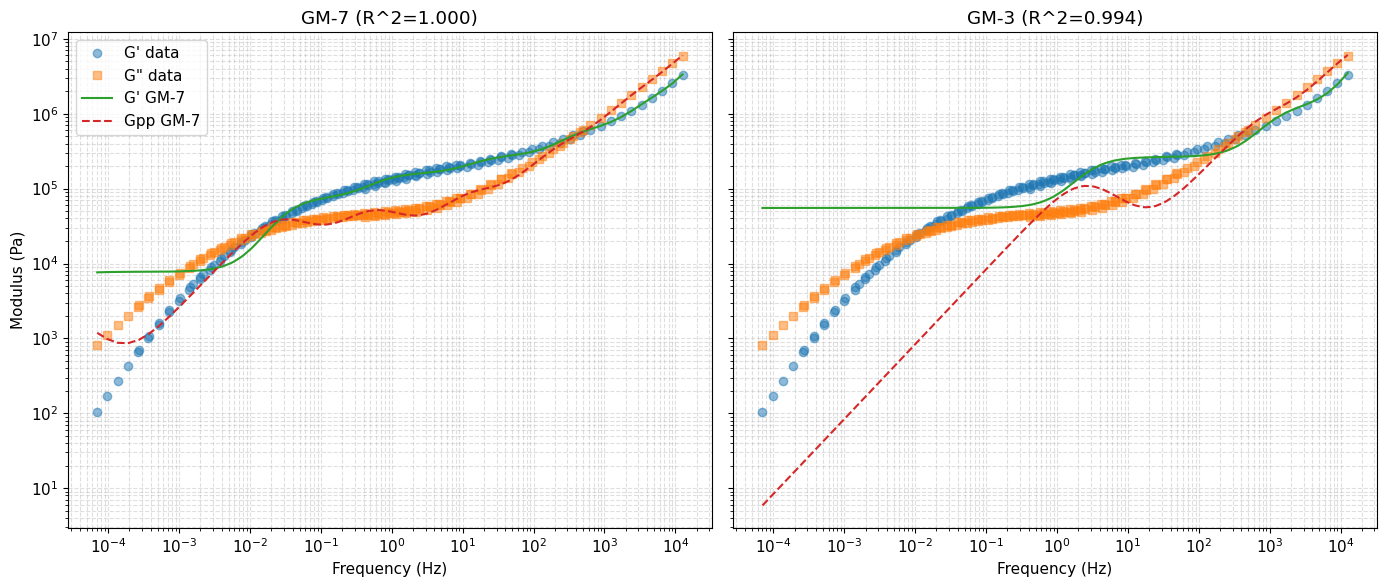

In [5]:
top2 = sorted([r for r in rows if np.isfinite(r['r2'])], key=lambda x: x['r2'], reverse=True)[:2]
freq_hz = omega/(2*np.pi)
fig, axes = plt.subplots(1, len(top2), figsize=(14,6), sharey=True)
for ax, rec in zip(axes, top2):
    model = dict(candidates)[rec['model']]
    model.fit(omega, G_star, test_mode='oscillation', use_log_residuals=True)
    pred = model.predict(omega)
    if pred.ndim == 2:
        pred = pred[:,0] + 1j*pred[:,1]
    ax.loglog(freq_hz, np.real(G_star), 'o', label="G' data", alpha=0.5)
    ax.loglog(freq_hz, np.imag(G_star), 's', label='G" data', alpha=0.5)
    ax.loglog(freq_hz, np.real(pred), '-', label=f"G' {rec['model']}")
    ax.loglog(freq_hz, np.imag(pred), '--', label=f"Gpp {rec['model']}")
    ax.set_title(f"{rec['model']} (R^2={rec['r2']:.3f})")
    ax.grid(True, which='both', ls='--', alpha=0.4)
for ax in axes:
    ax.set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Modulus (Pa)')
axes[0].legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 4 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.803453s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=0.803s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=7 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.772547s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=64 | final_cost=3.5477e+11 | elapsed=0.773s | final_gradient_norm=2.4860e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.555538s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=19 | final_cost=9.7350e+11 | elapsed=0.556s | final_gradient_norm=1.5303e+19


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.523954s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.7350e+11 | elapsed=0.524s | final_gradient_norm=6.9265e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.542811s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=47 | final_cost=9.7350e+11 | elapsed=0.543s | final_gradient_norm=6.9265e+08


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.334332s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=6 | final_cost=3.6883e+12 | elapsed=0.334s | final_gradient_norm=6.2810e+19


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.672144s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=0.672s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=15 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.672071s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=28 | final_cost=2.3737e+10 | elapsed=0.672s | final_gradient_norm=2.8484e+20


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=13 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.470287s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=3 | final_cost=4.1749e+10 | elapsed=0.470s | final_gradient_norm=5.2473e+17


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.641545s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=30 | final_cost=7.0994 | elapsed=0.642s | final_gradient_norm=0.0065


Dataset 0 ranking: [('GM-7', 1.0), ('GM-3', 0.994), ('GM-5', 0.983), ('FracMax', 0.285)]


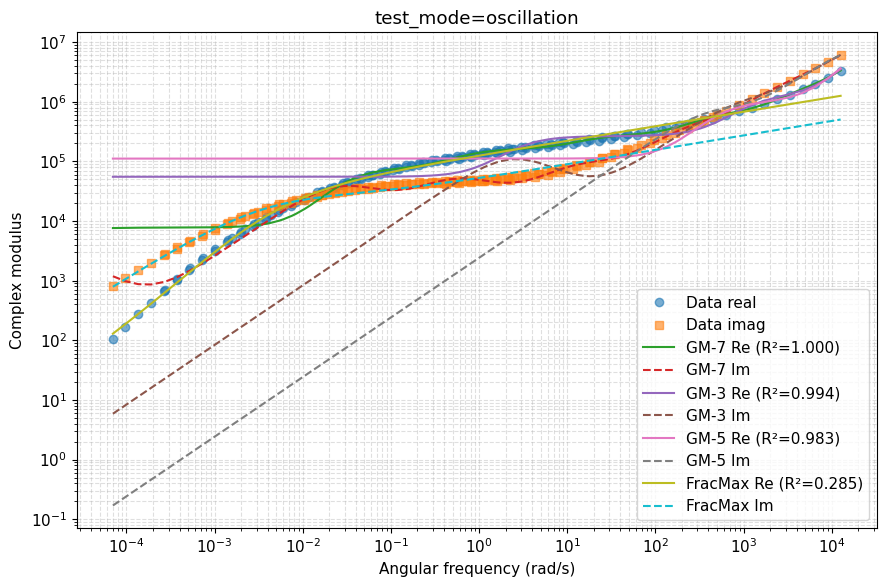

ERROR:rheojax.core.bayesian:bayesian_inference failed: Incompatible shapes for broadcasting: shapes=[(160, 2), (160,)]


ERROR:rheojax.core.base:Bayesian fit failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 215, in _broadcast_shapes_uncached
    return _try_broadcast_shapes(*rank_promoted_shapes, name='broadcast_shapes')
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 130, in _try_broadcast_shapes
    raise TypeError(f'{name} got incompatible shapes for broadcasting: '
                    f'{", ".join(map(str, map(tuple, shapes)))}.')
TypeError: broadcast_shapes got incompatible shapes for broadcasting: (160, 2), (1, 160).

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/jax/_src/lax/lax.py", line 193, in broadcast_shapes
    return _broadcast_shapes_cached(*shapes)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-p

Dataset 0: Bayesian step failed for GM-7: Incompatible shapes for broadcasting: shapes=[(160, 2), (160,)]


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: (bayes_result, param_names)}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        param_names = list(best['model'].parameters.keys())
        bayes_results[ds_idx] = (bayes_result, param_names)
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
for ds_idx, (bayes_result, param_names) in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    display_arviz_diagnostics(bayes_result, param_names, fast_mode=True)
